# Importing Libraries

In [31]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.utils import shuffle
import os, argparse, random, pickle, cv2, fnmatch
from os.path import join
from scipy import stats
from tensorflow.keras.optimizers import RMSprop
import random
import gc

print('Using Tensorflow version: {}, and Keras version: {}'.format(tf.__version__, keras.__version__))


Using Tensorflow version: 1.13.1, and Keras version: 2.2.4-tf


# Loading Numpy Arrays

In [4]:
print('[INFO] Loading Data & Labels...')

final_Array = np.load('Images_Data.npy')
final_Labels = np.load('Images_Labels.npy')

print('[INFO] Data loaded')

[INFO] Loading Data & Labels...
[INFO] Data loaded


# Visualising Data

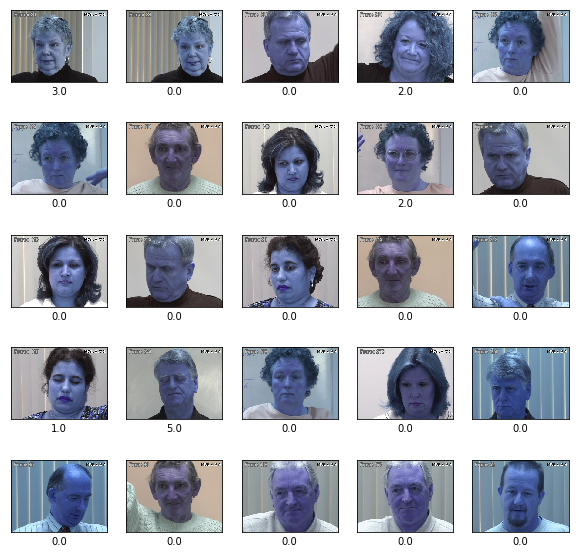

In [5]:
plt.figure(figsize=(10,10))
 
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(final_Array[i], cmap=plt.cm.binary)
    plt.xlabel(final_Labels[i])
plt.show()

# Splitting the Data

In [8]:
randomize = np.arange(len(final_Labels))
np.random.shuffle(randomize)
final_Labels = final_Labels[randomize]
final_Array = final_Array[randomize]

test_ratio = 0.2
split_location = int(final_Array.shape[0]*(1-test_ratio))
train_data = final_Array[:split_location]
test_data = final_Array[split_location:]

train_labels = final_Labels[:split_location]
test_labels = final_Labels[split_location:]

print('Train Data\t: {}\nTrain Labels\t: {}\nTest Data\t: {}\nTest Labels\t: {}'
      .format(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape))

Train Data	: (13391, 240, 320, 3)
Train Labels	: (13391,)
Test Data	: (3348, 240, 320, 3)
Test Labels	: (3348,)


In [9]:
train_data = train_data.reshape((13391, 240, 320, 3))
train_data = train_data.astype('float32') / 255

In [10]:
test_data = test_data.reshape((3348, 240, 320, 3))
test_data = test_data.astype('float32') / 255

In [11]:
for i in range(len(train_labels)):
    if train_labels[i] >= 1.0:
        train_labels[i] = 1
    else:
        train_labels[i] = 0

for i in range(len(test_labels)):
    if test_labels[i] >= 1.0:
        test_labels[i] = 1
    else:
        test_labels[i] = 0


# Define Functions and Classes

In [40]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val Accuracy')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 4)
    #(monitor='val_loss', patience=3)
    
def plot_image(i, predictions, test_labels, img):
    prediction, true_label, img = float(predictions[i]), float(test_labels[i]), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
 
    plt.imshow(img, cmap=plt.cm.binary)

    #predicted_label = np.argmax(predictions_array)
    if np.abs(prediction - true_label) < 0.3:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f'Predicted: {prediction:.2f}, True: {true_label:.2f}', color=color)

# Tensorflow Model
### Build

In [13]:
# def build_model():
#     model = keras.Sequential([
#       keras.layers.Flatten(),
#       keras.layers.Dense(1280, activation=tf.nn.relu),
#       tf.keras.layers.Dropout(0.2),
#       tf.keras.layers.Dense(1)#(16, activation=tf.nn.softmax)
#     ])

# #    model.compile(optimizer=tf.train.AdamOptimizer(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

#     model.compile(optimizer=tf.train.AdamOptimizer(), loss = 'mean_squared_error', metrics = ['mean_absolute_error','mean_squared_error'])
    
#     #model.compile(optimizer=tf.keras.optimizers.RMSprop(0.1), 
#     #              loss = 'mean_squared_error', 
#     #              metrics = ['mean_absolute_error', 'mean_squared_error'])
#     return model

# def create_and_compile_model(): 
#     model = k.models.Sequential([
#         k.layers.Conv2D(4, (3,3), activation='relu', input_shape=(*config['target_size'], 3),  name='mh-conv-1')
#         , k.layers.MaxPooling2D(4, 4, name='mh-maxpool-1')
#         , k.layers.Conv2D(8, (3,3), activation='relu', name='mh-conv-2')
#         , k.layers.MaxPooling2D(4,4, name='mh-maxpool-2')
# #         , k.layers.Conv2D(64, (3,3), activation='relu', name='mh-conv-3')
# #         , k.layers.MaxPooling2D(2,2, name='mh-maxpool-3')
# #         , k.layers.Conv2D(128, (3,3), activation='relu', name='mh-conv-4')
# #         , k.layers.MaxPooling2D(4,4, name='mh-maxpool-4')
#         , k.layers.Flatten(name='mh-flatten-1')
#         , k.layers.Dense(128, activation='relu', name='mh-dense-1')
#         , k.layers.Dense(1, activation='sigmoid', name='mh-dense-output')
#     ])
    
#     model.compile(
#         optimizer=RMSprop(lr=0.001)
#         , loss='binary_crossentropy'
# #         , metrics=[keras_metrics.precision(), keras_metrics.recall()]
#         , metrics=['accuracy']
#     )
    
#     return model

In [32]:
def build_model(num_layers, window_size, filters, drpout): 
    
    cnn_config = [keras.layers.Conv2D(filters, (window_size,window_size), activation=tf.nn.relu, input_shape=(240, 320, 3), padding = 'same', name='mh-conv-1')
                  , keras.layers.MaxPooling2D(4, 4, name='mh-maxpool-1')]
    
    for i in range(2,num_layers+1,1):
        cnn_config.append(keras.layers.Conv2D(filters*i, (window_size, window_size), activation=tf.nn.relu, name='mh-conv-' + str(i)))
        cnn_config.append(keras.layers.MaxPooling2D(4, 4, name='mh-maxpool-' + str(i)))
        
    cnn_config.append(keras.layers.Flatten(name='mh-flatten-1'))
    #cnn_config.append(keras.layers.Dropout(0.5))
    cnn_config.append(keras.layers.Dense(128, activation=tf.nn.relu, name='mh-dense-1'))
    #cnn_config.append(keras.layers.Dropout(0.2))
    #cnn_config.append(keras.layers.Dense(filters*(i-1), activation=tf.nn.relu, name='mh-dense-2'))
    #cnn_config.append(keras.layers.Dropout(0.2))
    cnn_config.append(keras.layers.Dense(1, activation='sigmoid', name='mh-dense-output'))
    
    
    model = keras.Sequential(cnn_config)
    model.compile(
        optimizer=RMSprop(lr=0.001)
        , loss='binary_crossentropy'
        , metrics=['accuracy', 'binary_crossentropy']
    )
    return model

### Training

In [33]:
try:
    del model
    print('Model cleared')
except:
    pass

try:
    keras.backend.clear_session()
    gc.collect()
    print('Session cleared')
except:
    pass
    

model = build_model(2, 3, 4, 0.2)
model.summary()


Session cleared
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mh-conv-1 (Conv2D)           (None, 240, 320, 4)       112       
_________________________________________________________________
mh-maxpool-1 (MaxPooling2D)  (None, 60, 80, 4)         0         
_________________________________________________________________
mh-conv-2 (Conv2D)           (None, 58, 78, 8)         296       
_________________________________________________________________
mh-maxpool-2 (MaxPooling2D)  (None, 14, 19, 8)         0         
_________________________________________________________________
mh-flatten-1 (Flatten)       (None, 2128)              0         
_________________________________________________________________
mh-dense-1 (Dense)           (None, 128)               272512    
_________________________________________________________________
mh-dense-output (Dense)      (None, 1)                 129  

In [34]:
history = model.fit(train_data, 
                    train_labels, 
                    epochs=20, 
                    batch_size=128,
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])
print('\nFitting Done!')


.................
Fitting Done!


### Evaluation

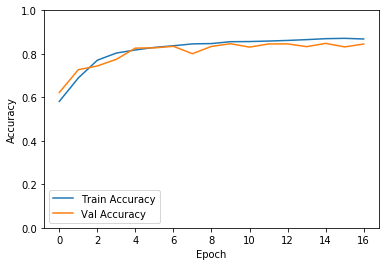

In [38]:
plot_history(history)

In [35]:
model.evaluate(test_data, test_labels)

3348/3348 [==============================] - 2s 697us/sample - loss: 0.3860 - acc: 0.8324 - binary_crossentropy: 0.3860


[0.3860247318889932, 0.8324373, 0.3860248]

### Samples

FIRST 25 PICTURES OF DATASET


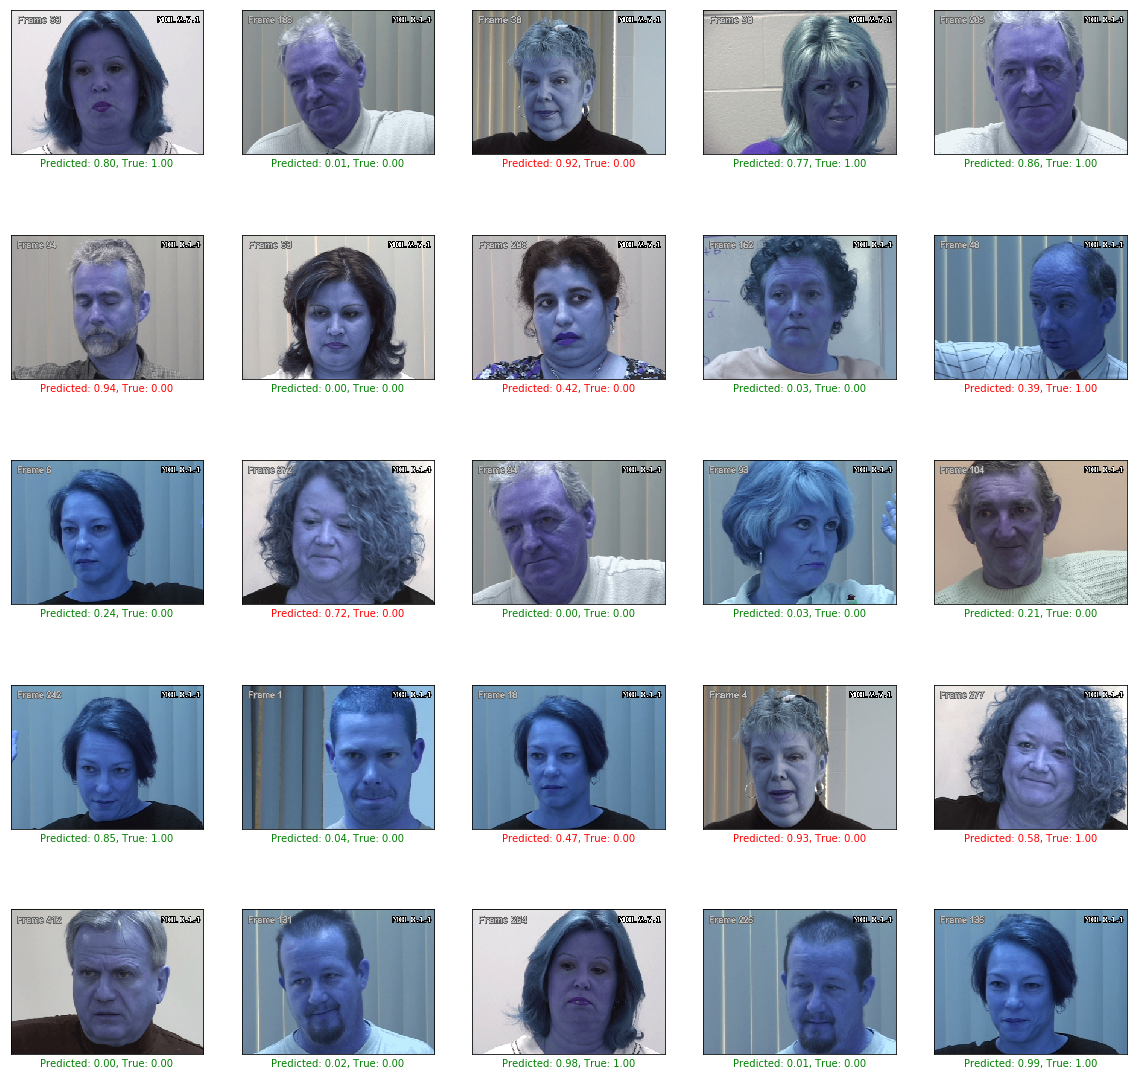

In [41]:
predictions = model.predict(test_data)
print("FIRST 25 PICTURES OF DATASET")
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*2*num_rows))
for i in range(num_images):
    j = random.randint(0,len(test_labels))
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(j, predictions, test_labels, test_data)
plt.show()

25 SAMPLE PICTURES WITH PSPI ABOVE 10


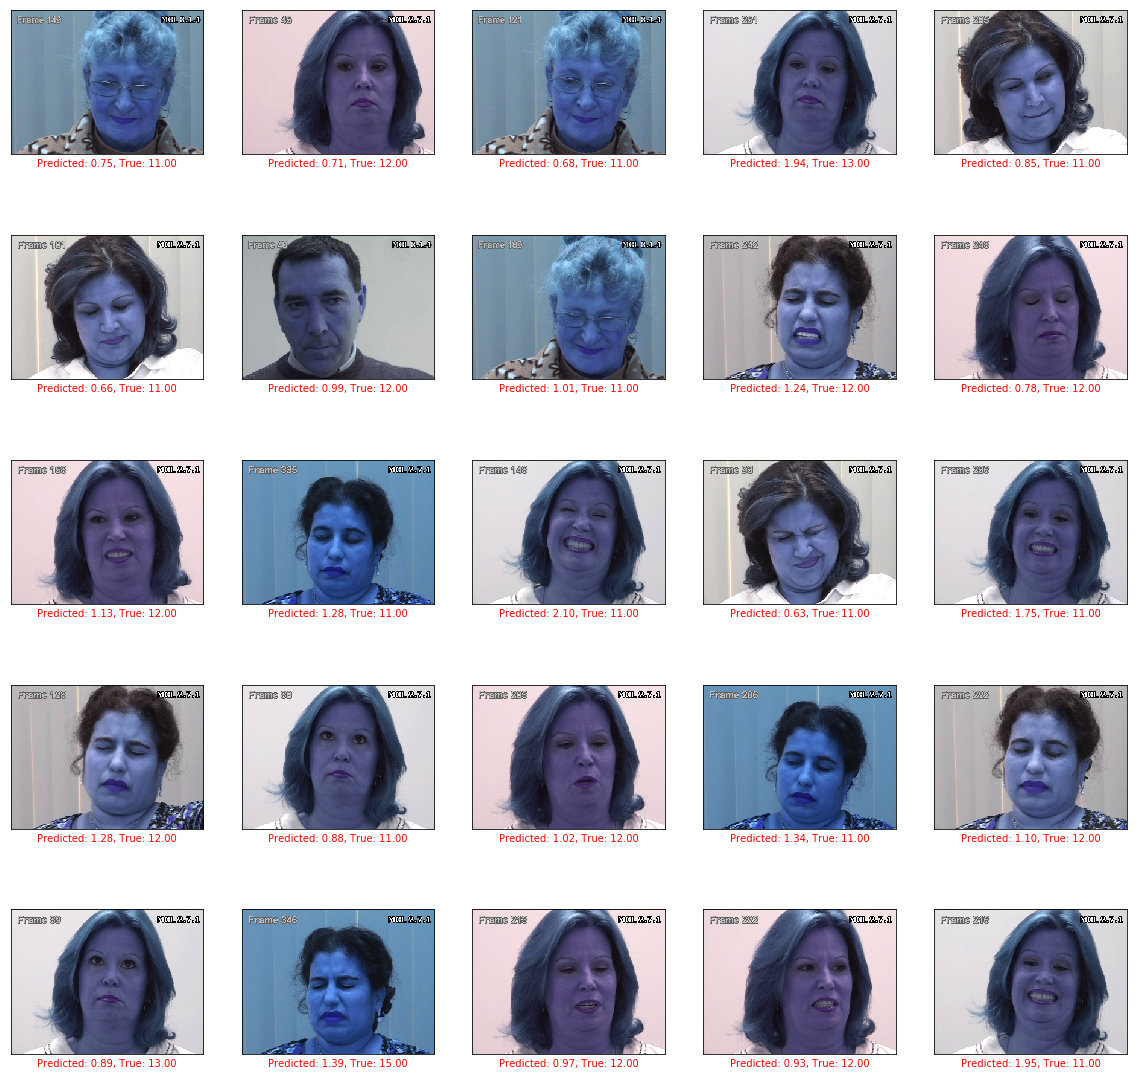

In [91]:
cut = 10
result = np.where(test_labels > cut)
print('25 SAMPLE PICTURES WITH PSPI ABOVE', cut)
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(i, predictions[result], test_labels[result], test_data[result])
plt.show()

In [72]:
data=[]
for i in range(len(test_labels)):
    data.append([test_labels[i],predictions[i][0],abs(test_labels[i]-predictions[i][0])])
df_predictions = pd.DataFrame(data,columns=['label','prediction','delta'])

In [82]:
# Mean of delta, for a given range
upper_range = 15.0
lower_range = 8.0

df_predictions[(df_predictions.delta > lower_range) & (df_predictions.delta < upper_range)]['delta'].mean()

9.954281225601832